**Data Preparation**

---

In [1]:
# Load data
import pandas as pd
import numpy as np
from google.colab import drive
from pandas import read_csv
drive.mount('/content/gdrive')
filename = 'gdrive/MyDrive/Dataset/IDXPartner/loan_data_2007_2014.csv'
dataframe = read_csv(filename)
dataframe.head()

Mounted at /content/gdrive


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Creating Y (Dependent) variable
dataframe.purpose.value_counts()

debt_consolidation    274195
credit_card           104157
home_improvement       26537
other                  23690
major_purchase          9828
small_business          7013
car                     5397
medical                 4602
moving                  2994
vacation                2487
wedding                 2343
house                   2269
educational              422
renewable_energy         351
Name: purpose, dtype: int64

In [3]:
def categorize_target(row):
  if row['loan_status'] == 'Fully Paid':
    return 0
  elif row['loan_status'] == 'Charged Off' or row['loan_status'] == 'Late (16-30 days)' or row['loan_status'] == 'Late (31-120 days)':
    return 1
  else:
    return 100 # Not Apllicable

dataframe['target'] = dataframe.apply(lambda row: categorize_target(row), axis=1)

In [4]:
dataframe['target'].value_counts()

100    230953
0      184739
1       50593
Name: target, dtype: int64

In [5]:
ori_df = dataframe
df = dataframe[dataframe['target'] <= 1].reset_index()

In [6]:
# Searching for a potential feature
df.emp_length.value_counts()

10+ years    70579
2 years      21944
< 1 year     19469
3 years      19062
5 years      17074
1 year       15665
4 years      15155
6 years      14114
7 years      13316
8 years      10931
9 years       8880
Name: emp_length, dtype: int64

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", size=14)
sns.set(style="whitegrid", color_codes=True)

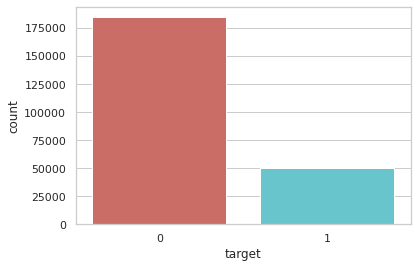

In [8]:
sns.countplot(x='target', data=df, palette='hls')
plt.show()

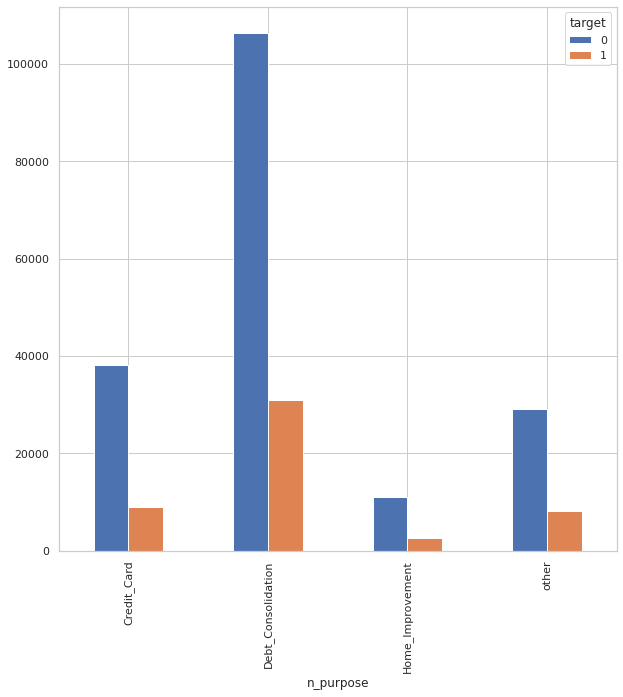

In [98]:
pd.crosstab(df.n_purpose, df.target).plot(kind='bar')

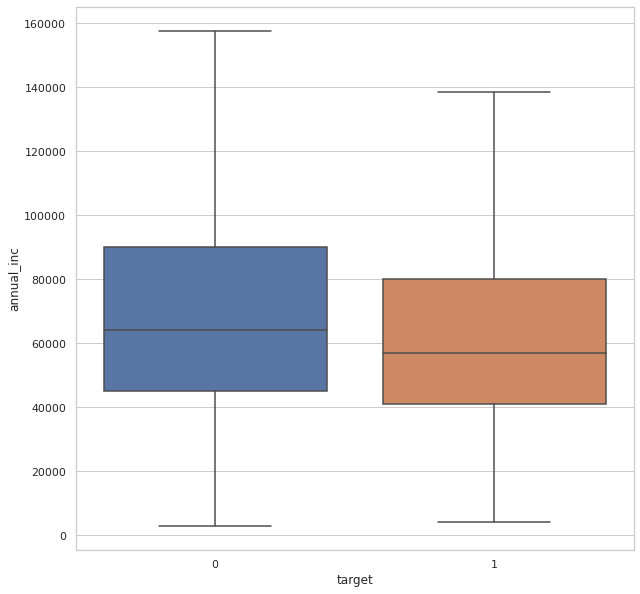

In [99]:
sns.boxplot(x='target', y='annual_inc', data=df, showfliers=False)

In [10]:
# Binning low quantity cateogry
df['n_home_ownership'] = np.where(df['home_ownership'].
                                  isin(['MORTGAGE', 'OWN', 'RENT']),
                                  df['home_ownership'].
                                  str.title(), 'OTHER'
                                  )
df['n_purpose'] = np.where(df['purpose'].
                           isin(['debt_consolidation', 'credit_card', 'home_improvement']),
                           df['purpose'].
                           str.title(), 'other'
                           )

In [11]:
# String Formatting
df['emp_length'] = df['emp_length'].replace(['< 1 year'], '0-1 year')

In [45]:
# Preparing categorical features
categorical_column = ['term', 'grade', 'emp_length', 
                      'n_home_ownership',
                      'n_purpose']
categorical_dataframe = df[categorical_column]
cat_feat = pd.get_dummies(df[categorical_column])

In [13]:
# Preparing numerical features
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

numerical_column = ['int_rate', 'annual_inc']
numerical_dataframe = df[numerical_column]
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaled_numerical_dataframe = scaler.fit_transform(numerical_dataframe)
num_feat = pd.DataFrame(scaled_numerical_dataframe, columns=numerical_column)

In [83]:
x = cat_feat.merge(num_feat, left_index=True, right_index=True)
#x = cat_feat
y = df['target']

In [84]:
x = x.apply(pd.to_numeric)
y = y.apply(pd.to_numeric)

In [85]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [86]:
# SMOTE for imbalance data
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

In [87]:
import statsmodels.api as sm

logit_model = sm.Logit(y_train, x_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.630760
         Iterations 6
                                 Results: Logit
Model:                    Logit                Pseudo R-squared:     0.090      
Dependent Variable:       target               AIC:                  326440.6336
Date:                     2023-01-29 12:19     BIC:                  326754.5387
No. Observations:         258720               Log-Likelihood:       -1.6319e+05
Df Model:                 29                   LL-Null:              -1.7933e+05
Df Residuals:             258690               LLR p-value:          0.0000     
Converged:                1.0000               Scale:                1.0000     
No. Iterations:           6.0000                                                
--------------------------------------------------------------------------------
                              Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------

In [88]:
# Drop feature with p-values bigger than 0.05
dropped_cols = ['term_ 60 months', 'n_home_ownership_Mortgage',
                'n_home_ownership_Own', 'n_home_ownership_Rent']
x_train = x_train.drop(dropped_cols, axis=1)
x_test = x_test.drop(dropped_cols, axis=1)

In [89]:
logit_model = sm.Logit(y_train, x_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.631129
         Iterations 6
                                 Results: Logit
Model:                    Logit                Pseudo R-squared:     0.089      
Dependent Variable:       target               AIC:                  326623.2219
Date:                     2023-01-29 12:21     BIC:                  326895.2730
No. Observations:         258720               Log-Likelihood:       -1.6329e+05
Df Model:                 25                   LL-Null:              -1.7933e+05
Df Residuals:             258694               LLR p-value:          0.0000     
Converged:                1.0000               Scale:                1.0000     
No. Iterations:           6.0000                                                
--------------------------------------------------------------------------------
                              Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------

**Modeling & Evaluation**

---



In [90]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg_m = LogisticRegression(max_iter=400)
logreg_m.fit(x_train, y_train)
y_pred = logreg_m.predict(x_test)

In [91]:
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6280453257790368
              precision    recall  f1-score   support

           0       0.87      0.62      0.72     55379
           1       0.32      0.66      0.43     15221

    accuracy                           0.63     70600
   macro avg       0.60      0.64      0.58     70600
weighted avg       0.75      0.63      0.66     70600



In [92]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rfm = RandomForestClassifier()
rfm.fit(x_train, y_train)
y_pred = rfm.predict(x_test)

In [93]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6592351274787536
              precision    recall  f1-score   support

           0       0.82      0.73      0.77     55379
           1       0.29      0.40      0.33     15221

    accuracy                           0.66     70600
   macro avg       0.55      0.56      0.55     70600
weighted avg       0.70      0.66      0.68     70600



In [94]:
# XGBoost
import xgboost as xgb

xgbm = xgb.XGBClassifier()
xgbm.fit(x_train, y_train)
y_pred = xgbm.predict(x_test)

In [97]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6502407932011331
              precision    recall  f1-score   support

           0       0.86      0.67      0.75     55379
           1       0.33      0.59      0.42     15221

    accuracy                           0.65     70600
   macro avg       0.59      0.63      0.59     70600
weighted avg       0.74      0.65      0.68     70600

